<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# x_val = x_train[-10000:]
# y_val = y_train[-10000:]
# x_train = x_train[:-10000]
# y_train = y_train[:-10000]

In [5]:
w_init = initializers.glorot_normal()
b_init = initializers.Zeros()

In [6]:
model = tf.keras.Sequential()

drop_out = 0.30
lern_rat = 0.001
neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 1, activation='relu', kernel_initializer=w_init, bias_initializer=b_init)) #, kernel_regularizer=regularizers.l2(lern_rat)
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 2, activation='tanh'))
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 2, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

# model.add(layers.Dense(neurons * 2, activation='relu'))
# model.add(BatchNormalization())
# model.add(layers.Dropout(drop_out * 2))

model.add(layers.Dense(10, activation='softmax'))

In [7]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) # sparse_categorical_accuracy

1/1 [==============================] - 0s 303ms/step


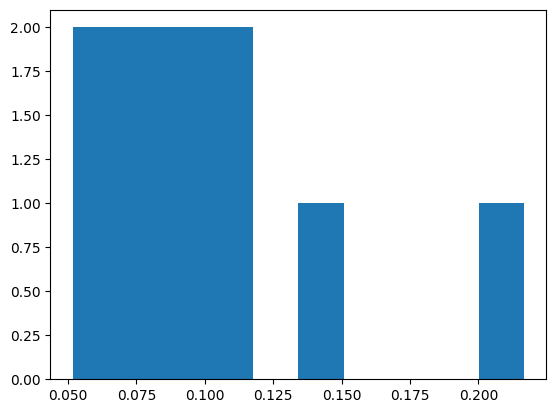

In [8]:
x = np.random.random((1, 28, 28))
a = model.predict(x)
_ = plt.hist(np.transpose(a))

In [9]:
y_pred = model.predict(x_test)

313/313 [==============================] - 2s 6ms/step


In [10]:
callback = callbacks.EarlyStopping(monitor='val_loss',
                                   patience=50,
                                   restore_best_weights=True,
                                   )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='sparse_categorical_accuracy', mode='max', verbose=0, save_best_only=True)


In [11]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc],
                    verbose=1, #многословие
                    validation_split=0.2
                    # validation_data=(x_val, y_val)
                    )
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/100
375/375 [==============================] - 13s 29ms/step - loss: 0.7367 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.5186 - val_sparse_categorical_accuracy: 0.8083
Epoch 2/100
  4/375 [..............................] - ETA: 7s - loss: 0.5404 - sparse_categorical_accuracy: 0.8008

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 9s 24ms/step - loss: 0.5202 - sparse_categorical_accuracy: 0.8102 - val_loss: 0.4214 - val_sparse_categorical_accuracy: 0.8466
Epoch 3/100
375/375 [==============================] - 11s 28ms/step - loss: 0.4695 - sparse_categorical_accuracy: 0.8249 - val_loss: 0.3820 - val_sparse_categorical_accuracy: 0.8593
Epoch 4/100
375/375 [==============================] - 10s 28ms/step - loss: 0.4449 - sparse_categorical_accuracy: 0.8357 - val_loss: 0.3557 - val_sparse_categorical_accuracy: 0.8693
Epoch 5/100
375/375 [==============================] - 10s 26ms/step - loss: 0.4256 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.3711 - val_sparse_categorical_accuracy: 0.8640
Epoch 6/100
375/375 [==============================] - 10s 26ms/step - loss: 0.4188 - sparse_categorical_accuracy: 0.8435 - val_loss: 0.3636 - val_sparse_categorical_accuracy: 0.8670
Epoch 7/100
375/375 [==============================] - 10s 28ms/step - loss: 0.4089 - sparse_categ

In [12]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


In [13]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 4ms/step - loss: 0.3021 - sparse_categorical_accuracy: 0.8925
[0.30212822556495667, 0.8924999833106995]


In [14]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 4ms/step - loss: 0.2993 - sparse_categorical_accuracy: 0.8925
[0.29925552010536194, 0.8924999833106995]


In [15]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

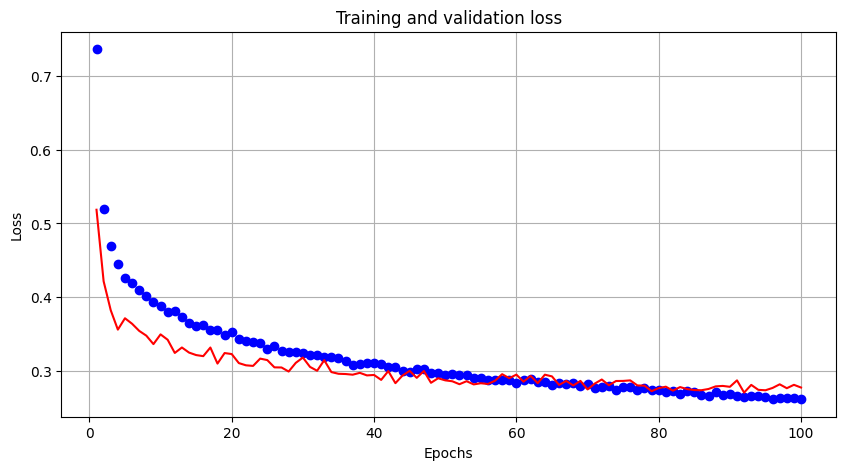

<Figure size 640x480 with 0 Axes>

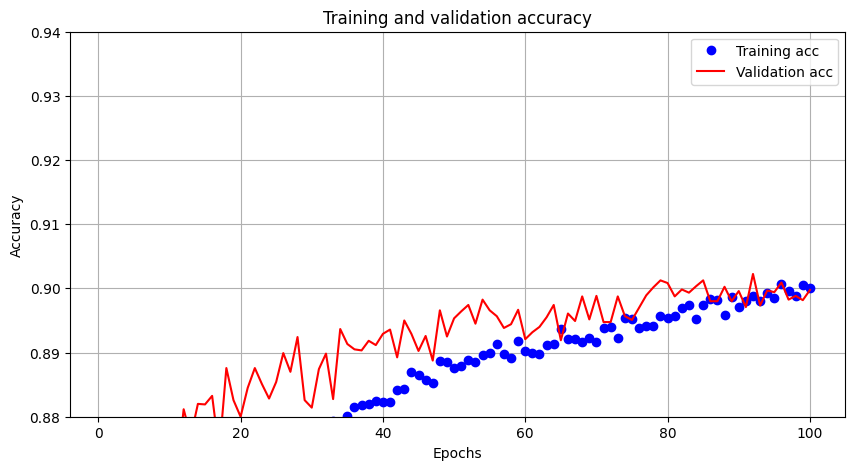

In [16]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'r', label='Validation acc')
plt.ylim (0.88, 0.94)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [17]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [18]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


In [19]:
predictions[0]

array([0.08549009, 0.08549009, 0.0854901 , 0.08549011, 0.0854901 ,
       0.08552083, 0.0854901 , 0.08652528, 0.08549009, 0.22952323],
      dtype=float32)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                        